# Music Genre Classification using Neural Networks

## Objectives

1. Convert data into a suitable format to be analysed.
2. Evaluate various neural network architectures in classifying the music.
3. Evaluate optimisers and callbacks.
4. Create a final model.

## Background
### Our data
We are using the FMA small dataset from the Free Music Archive [5]. This dataset contains 8000 tracks (mp3 files) each of length 30 seconds, with 1000 tracks each from 8 different genres. The genres are Electronic, Hip-Hop, Instrumental, Rock, Experimental, Folk, International and Pop. We are also using the tracks.csv file from the fma_metadata.zip file, this includes per track metadata such as ID, title, artist, genres, tags and plays counts for all the tracks.

### The genres
Each genre has its own defining characteristics. Dynamic range describes the difference between the quietest and loudest volume of the piece of music.
#### Electronic
Electronic music is music that is at least partially created using electronic musical instruments, digital instruments and circuitry-based music technology.
#### Hip-Hop
Usually has a flat dynamic range (little difference) and involves rhyming/rhythmic speech. The rapping is accompanied by an instrumental track, referred to as a "beat" because of the emphasis on rhythm, the beat is often created using a sample of the percussion break of other genres. Distinctive features include; heavy basslines, a tempo of about 70-100 beats per minute, syncopated drum beats and deep, meaningful lyrics.
#### Instrumental
An instrumental is a music recording without any vocals.
#### Rock
Typically rock has centred on the electric guitar, with electric bass, drums, and one or more singers supporting it.
#### Experimental
Experimental music is a label used to describe any music that pushes existing genre definitions. It consciously deviates from established musical norms.
#### Folk
Typically lyrics originate from ongoing or historical events. An acoustic guitar is a very common instrument used and is usually accompanied by other acoustic instruments.
#### International
This is a broad term used to describe music created outside British or North American traditions. It can encompass anything from traditional Chinese music to African folk.
#### Pop
Pop music is meant to appeal to just about everyone that would listen and is therefore very commercial. It does not have any distinctive characteristics of its own and over the years it has enveloped almost every genre from Motown to metal, hip-hop to drum and bass.

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
import AI_methods as ai
import json
import tensorflow as tf
tf.__version__
from tensorflow import keras
from tensorflow.keras import layers
%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8417595822363369929
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6657650197
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13450961114517704161
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


This is a hip hop track, and we can visualise this piece of music using a wave plot.

In [3]:
df = ai.get_track_data()
df.head(10)

,split,genre,track_id
track_id,,,
2,training,Hip-Hop,2
5,training,Hip-Hop,5
10,training,Pop,10
140,training,Folk,140
141,training,Folk,141
148,validation,Experimental,148
182,test,Rock,182
190,training,Folk,190
193,training,Folk,193


In [4]:
import IPython.display as ipd
filename = ai.get_path(2)
ipd.Audio(filename)# Click play to listen to the audio

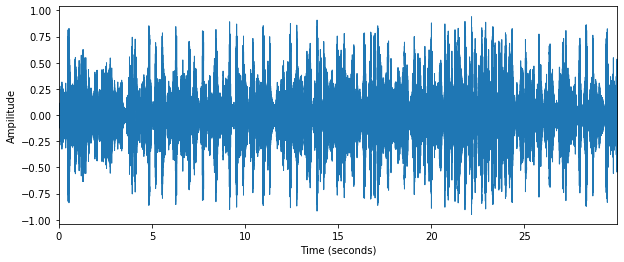

In [5]:
y, sr = librosa.load(filename)
plt.figure(figsize=(10, 4))
librosa.display.waveplot(y, sr)
plt.xlabel("Time (seconds)")
plt.ylabel("Ampilitude")
plt.show()

## Melspectograms
An audio signal is made up of several single-frequency sound waves. We can only capture the resulting amplitudes. From this, we can use the Fourier transform [0] that lets us decompose a signal into its individual frequencies and the frequency’s amplitude.

$$ f(t) = \int_{-\infty}^{\infty} f\hat(\nu)*e^{2it\nu\pi} d\nu $$
We use the equation above where t represents time and the transform variable $\nu$ represents frequency.

Fourier’s theorem tells us that every reasonably continuous periodic function can be decomposed into a set of sine and cosine waves. When we use the transform we can convert the signal (amplitude vs time) into a spectrum (amplitude vs frequency).

The fast Fourier transform (FFT) is an algorithm that is commonly used to compute the Fourier transform. As audio signals such as music are non-periodic we compute several spectrums on several windowed segments of the signal this is known as the short-time Fourier transform. We do this on overlapping windowed segments of the signal, and then convert the frequency to the log(frequency) and convert amplitude to decibels using:
$$ I = \frac{ A_p^2 }{2v\rho}$$
$$ dB = 10* log_{10}(I/I_0) $$ 

Where I represents intensity, $A_p$ is pressure amplitude, $\rho$ is the density of the material in which the sound wave travels, and v is the speed of sound in that material. The reference intensity $I_0$, corresponding to a level of 0 decibels [2]. We get a spectrogram (Where frequency is on the y-axis, time on the x-axis, and decibels representing colour). 

As we are much better at perceiving differences at lower frequencies than higher ones, the mel scale was proposed such that equal distances in pitch sounded equally distant to the listener. Then we covert from frequency to the mel-scale, using the formula $M(f) = 1125*ln(1 + f/700)$. This gives us a mel spectrogram. In a Mel spectrogram the x-axis is time(seconds) y-axis is frequency(mel-scale) and the colour dimension is amplitude(decibels). See below the plots of melspectograms for a variety of music genres.

In [6]:
grouped_df = df.groupby('genre').first().reset_index()
grouped_df.head(10)

,genre,split,track_id
0,Electronic,training,1482
1,Experimental,validation,148
2,Folk,training,140
3,Hip-Hop,training,2
4,Instrumental,test,10250
5,International,training,666
6,Pop,training,10
7,Rock,test,182


(128, 128)


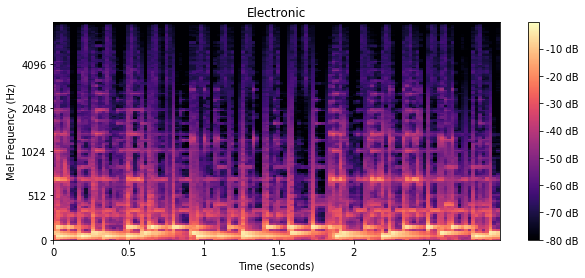

(128, 128)


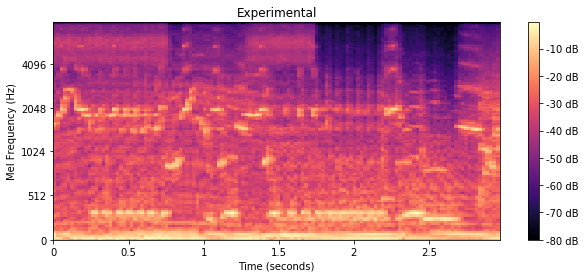

(128, 128)


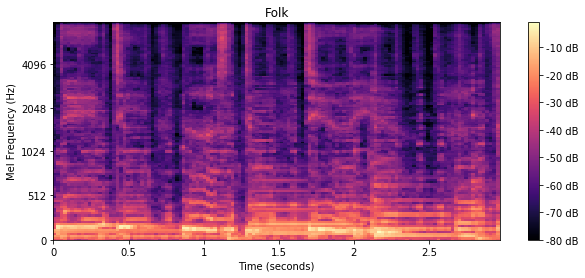

(128, 128)


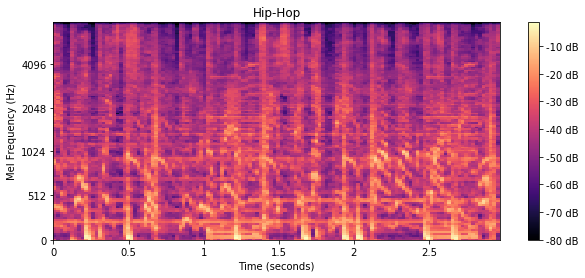

(128, 128)


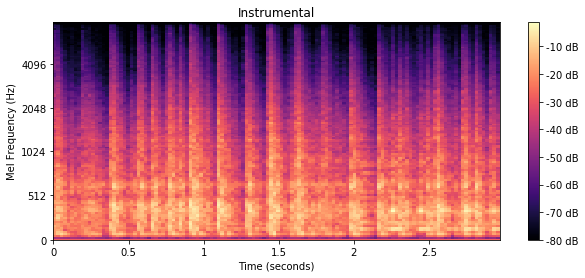

(128, 128)


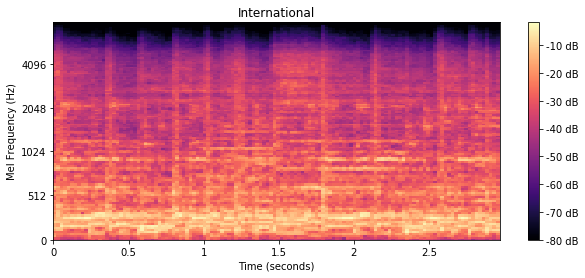

(128, 128)


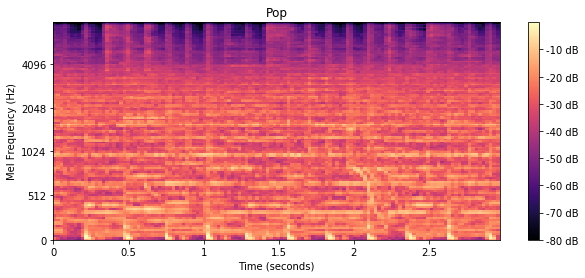

(128, 128)


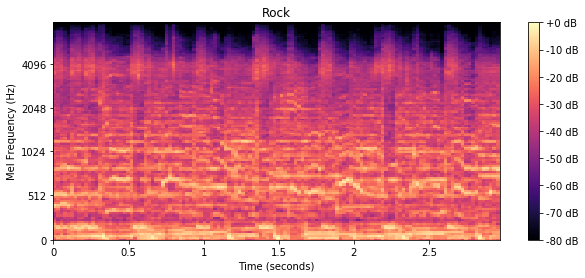

In [7]:
for index, row in grouped_df.iterrows():
    track_id = int(row['track_id'])
    genre = row[('genre')]
    ai.plot_spectogram(track_id, genre)

As we can see from the plots above there does seem to be visual differences in the melspectograms between music genres.
## Transforming the data
Initially, the ram on my computer wasn’t large enough to hold the whole data in the jupyter notebook, so I ended up buying 16GB more ram for it.
After creating and testing on a basic three-layer feed-forward neural net, I was starting to have resource exhaustion errors. After reducing the number of classes from eight to four and using small batch sizes (around twenty), this error stopped occurring. I did not want to limit myself to this smaller dataset and limited models so I thought of an alternate solution. Each spectrogram is 128x640 (81920 values) in dimension, this is significantly larger than the images we have classified so far in the course, MNIST is 28x28 (784 values) and CIFAR-10 is 32x32x3 (3072 values). I reduced the size of each spectrogram by doing the following:

1. Reduced the length of each sound clip from 15 seconds to 3 seconds, I used the middle part of each audio file, as this was very representative of the majority of the piece.
2. I did this three times so I could triple the size of our training set which was only 6400 before, and now it is 19200.
3. I then used tf.image.resize to resize the tensor from 128x128 to 64x64, the method used to do this is bi-linear interpolation [3].

As a result, now each spectrogram is 64x64 (4096 values), this has allowed me to continue using all eight classes and reasonable batch sizes.

Bi-linear interpolation is an extension of linear interpolation on a 2D grid. First, we linearly interpolate on one axis and next interpolate on the other axis. It does not matter which axis we start off with. E.g. suppose we have four points $Q_{11} = (x1, y1)$, $Q_{12} = (x1, y2)$, $Q_{21} = (x2, y1)$, and $Q_{22} = (x2, y2)$.

![Final Results](Project_pictures/bilinear.png)

### Before scaling

(128, 646)


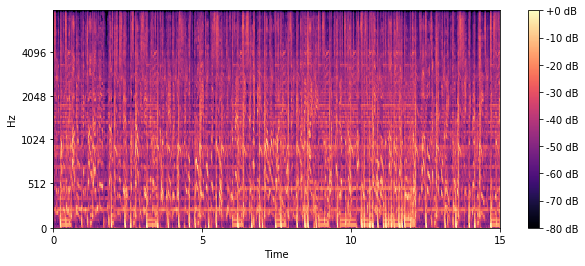

In [8]:
y, sr = librosa.load(ai.get_path(2))
spectrogram = librosa.feature.melspectrogram(y = y, sr = sr, n_fft = 2048, hop_length = 1024)
spectrogram = librosa.power_to_db(spectrogram, ref = np.max)
print(spectrogram.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.show()

(128, 128)


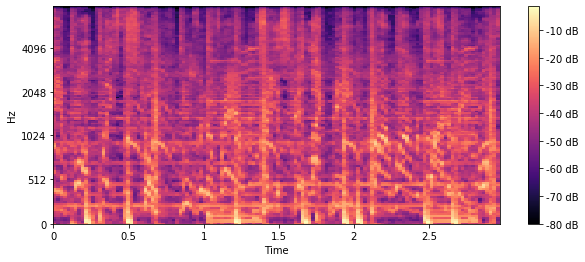

In [9]:
# Shortening to 3 seconds
print(spectrogram[:, 215:343].shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram[:, 215:343], y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.show()

(64, 64)


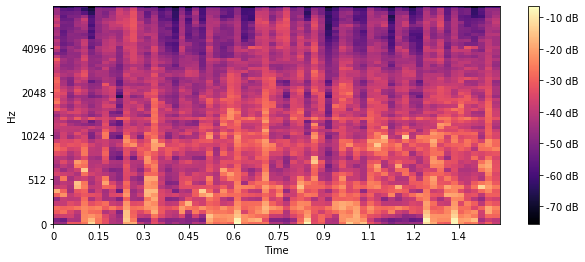

In [10]:
# After bi-linear interpolation
im1 = ai.resize_data(spectrogram[:, 215:343])
print(im1.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(im1, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.show()

## converting data to npz files

In [11]:
df['genre'].value_counts() # Number of tracks in each genre

Hip-Hop          1000
Instrumental     1000
Electronic       1000
Pop              1000
Experimental     1000
Folk             1000
Rock             1000
International    1000
Name: genre, dtype: int64

In [12]:
df['split'].value_counts() 

training      6400
test           800
validation     800
Name: split, dtype: int64

In [13]:
df_test = df[df['split'] == 'test']
print (df_test.shape)
df_valid = df[df['split'] == 'validation']
print (df_valid.shape)
df_train = df[df['split'] == 'training']
print (df_train.shape)

(800, 3)
(800, 3)
(6400, 3)


In [18]:
genre_dict = {'Electronic':0,  'Hip-Hop':1, 
               'Instrumental':2, 'Rock': 3, 'Experimental':4, 'Folk':5, 'International':6, 'Pop' :7,}

#### Convert and store data
A similar process is used to save other slices of the spectrogram.

In [ ]:
#X, Y = ai.convert_data(df_test)
#np.savez('test_data.npz', X, Y)

In [ ]:
#X, Y = ai.convert_data(df_train)
#np.savez('train_data.npz', X, Y)

In [ ]:
#X, Y = ai.convert_data(df_valid)
#np.savez('validation_dat.npz', X, Y)

#### Loading and merging the data

In [3]:
X_valid, Y_valid = ai.get_valid_data()
print(X_valid.shape, Y_valid.shape)
X_test, Y_test = ai.get_test_data()
print(X_test.shape, Y_test.shape)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
(1600, 64, 64) (1600, 8)
(1600, 64, 64) (1600, 8)


In [4]:
npzfile = np.load('data/train_dat.npz')
X = npzfile['arr_0']
Y = npzfile['arr_1']
X_t1, Y_t1 = ai.standardise_data(X, Y)
print(X_t1.shape, Y_t1.shape)
npzfile = np.load('data/train_dat1.npz')
X = npzfile['arr_0']
Y = npzfile['arr_1']
X_t2, Y_t2 = ai.standardise_data(X, Y)
print(X_t2.shape, Y_t2.shape)
npzfile = np.load('data/train_dat2.npz')
X = npzfile['arr_0']
Y = npzfile['arr_1']
X_t3, Y_t3 = ai.standardise_data(X, Y)
print(X_t3.shape, Y_t3.shape)

(6394, 64, 64) (6394, 8)
(6394, 64, 64) (6394, 8)
(6394, 64, 64) (6394, 8)


In [5]:
X_train = tf.concat([X_t1, X_t2, X_t3], 0)
Y_train = tf.concat([Y_t1, Y_t2, Y_t3], 0)
print(X_train.shape, Y_train.shape)

(19182, 64, 64) (19182, 8)


## Comparing custom learning rates using our first model

Our first model is a four-layer feed-forward neural network.

#### Defining the learning rates

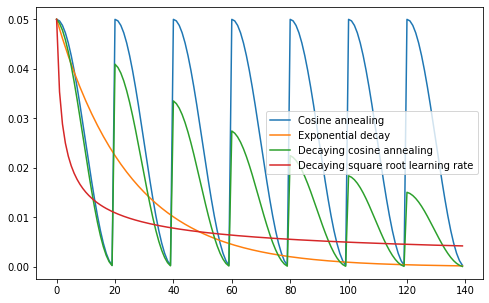

In [6]:
import math

# cosine annealing learning rate schedule
def cosine_annealing(epoch):
    start_lr = 0.05
    epochs_per_cycle = 20
    cos_inner = (math.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
    return start_lr/2 * (math.cos(cos_inner) + 1)

def exp_dec(epoch):
    start_lr = 0.05
    return start_lr * np.exp(-epoch/25)

def cos_exp(epoch):
    x = cosine_annealing(epoch)
    return x * np.exp(-epoch/100)

def sqroot(epoch):
    start_lr = 0.05
    return start_lr/math.sqrt(epoch+1)

plt.figure(figsize = (8,5))
series_ca = [cosine_annealing(i) for i in range(140)]
plt.plot(series_ca, label='Cosine annealing')
series_exp = [exp_dec(i) for i in range(140)]
plt.plot(series_exp, label='Exponential decay')
series_cexp = [cos_exp(i) for i in range(140)]
plt.plot(series_cexp, label='Decaying cosine annealing')
series_sqr = [sqroot(i) for i in range(140)]
plt.plot(series_sqr, label='Decaying square root learning rate')
plt.legend()
plt.show()

In [7]:
cos_lr = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
exp_lr = tf.keras.callbacks.LearningRateScheduler(exp_dec)
cexp_lr = tf.keras.callbacks.LearningRateScheduler(cos_exp)
sqr_lr = tf.keras.callbacks.LearningRateScheduler(sqroot)
lr_list = [cos_lr, exp_lr, cexp_lr, sqr_lr]

These are the four learning rates we will use, and we will also compare its performance to using the Adam (Adaptive Moment Estimation) optimiser which has its own learning rate.

In [10]:
history_list_FFNN = []

for l in lr_list:
    model_FFNN = keras.Sequential([
        layers.Flatten(),
        layers.Dense(units=256, activation='relu'),
        layers.Dropout(0.15),
        layers.Dense(units=128, activation='relu'),
        layers.Dropout(0.15),
        layers.Dense(units=64, activation='relu'),
        layers.Dropout(0.15),
        layers.Dense(units=32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(units=8, activation='softmax')
    ])
    model_FFNN.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD'),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    history_FFNN = model_FFNN.fit(X_train, Y_train, epochs=280, batch_size=250, validation_data=(X_test, Y_test), shuffle = True, 
                      callbacks = [l])
    history_list_FFNN.append(history_FFNN)

model_FFNN.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_FFNN1 = model_FFNN.fit(X_train, Y_train, epochs=280, batch_size=250, validation_data=(X_test, Y_test), shuffle = True)
history_list_FFNN.append(history_FFNN1)

Train on 19182 samples, validate on 1600 samples
Epoch 1/280
19182/19182 [==============================] - 1s 53us/sample - loss: 2.0361 - accuracy: 0.2058 - val_loss: 2.0162 - val_accuracy: 0.2225
Epoch 2/280
19182/19182 [==============================] - 1s 28us/sample - loss: 2.0027 - accuracy: 0.2510 - val_loss: 2.0093 - val_accuracy: 0.2450
Epoch 3/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.9778 - accuracy: 0.2855 - val_loss: 1.9858 - val_accuracy: 0.2713
Epoch 4/280
19182/19182 [==============================] - 1s 27us/sample - loss: 1.9628 - accuracy: 0.3024 - val_loss: 1.9900 - val_accuracy: 0.2675
Epoch 5/280
19182/19182 [==============================] - 1s 27us/sample - loss: 1.9491 - accuracy: 0.3169 - val_loss: 1.9936 - val_accuracy: 0.2625
Epoch 6/280
19182/19182 [==============================] - 1s 27us/sample - loss: 1.9415 - accuracy: 0.3243 - val_loss: 1.9821 - val_accuracy: 0.2750
Epoch 7/280
19182/19182 [==========================

Epoch 55/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.7997 - accuracy: 0.4750 - val_loss: 1.9262 - val_accuracy: 0.3388
Epoch 56/280
19182/19182 [==============================] - 1s 27us/sample - loss: 1.7989 - accuracy: 0.4762 - val_loss: 1.9270 - val_accuracy: 0.3325
Epoch 57/280
19182/19182 [==============================] - 1s 27us/sample - loss: 1.7948 - accuracy: 0.4827 - val_loss: 1.9246 - val_accuracy: 0.3325
Epoch 58/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.7963 - accuracy: 0.4785 - val_loss: 1.9259 - val_accuracy: 0.3363
Epoch 59/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.7948 - accuracy: 0.4813 - val_loss: 1.9262 - val_accuracy: 0.3363
Epoch 60/280
19182/19182 [==============================] - 1s 27us/sample - loss: 1.7972 - accuracy: 0.4793 - val_loss: 1.9258 - val_accuracy: 0.3338
Epoch 61/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8112 - ac

Epoch 163/280
19182/19182 [==============================] - 1s 30us/sample - loss: 1.6771 - accuracy: 0.5991 - val_loss: 1.9221 - val_accuracy: 0.3375
Epoch 164/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.6716 - accuracy: 0.6045 - val_loss: 1.9198 - val_accuracy: 0.3462
Epoch 165/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.6631 - accuracy: 0.6133 - val_loss: 1.9325 - val_accuracy: 0.3400
Epoch 166/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.6546 - accuracy: 0.6223 - val_loss: 1.9220 - val_accuracy: 0.3400
Epoch 167/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6487 - accuracy: 0.6281 - val_loss: 1.9145 - val_accuracy: 0.3487
Epoch 168/280
19182/19182 [==============================] - 1s 27us/sample - loss: 1.6433 - accuracy: 0.6341 - val_loss: 1.9242 - val_accuracy: 0.3512
Epoch 169/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.63

Epoch 217/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.5595 - accuracy: 0.7198 - val_loss: 1.9294 - val_accuracy: 0.3288
Epoch 218/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.5581 - accuracy: 0.7210 - val_loss: 1.9305 - val_accuracy: 0.3363
Epoch 219/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.5561 - accuracy: 0.7229 - val_loss: 1.9282 - val_accuracy: 0.3313
Epoch 220/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.5559 - accuracy: 0.7230 - val_loss: 1.9281 - val_accuracy: 0.3350
Epoch 221/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.6250 - accuracy: 0.6512 - val_loss: 1.9616 - val_accuracy: 0.3075
Epoch 222/280
19182/19182 [==============================] - 1s 27us/sample - loss: 1.6308 - accuracy: 0.6453 - val_loss: 1.9428 - val_accuracy: 0.3175
Epoch 223/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.61

Epoch 271/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.5349 - accuracy: 0.7419 - val_loss: 1.9382 - val_accuracy: 0.3275
Epoch 272/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.5283 - accuracy: 0.7497 - val_loss: 1.9270 - val_accuracy: 0.3400
Epoch 273/280
19182/19182 [==============================] - 1s 30us/sample - loss: 1.5275 - accuracy: 0.7504 - val_loss: 1.9424 - val_accuracy: 0.3187
Epoch 274/280
19182/19182 [==============================] - 1s 33us/sample - loss: 1.5219 - accuracy: 0.7549 - val_loss: 1.9312 - val_accuracy: 0.3300
Epoch 275/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.5174 - accuracy: 0.7598 - val_loss: 1.9324 - val_accuracy: 0.3288
Epoch 276/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.5157 - accuracy: 0.7619 - val_loss: 1.9324 - val_accuracy: 0.3313
Epoch 277/280
19182/19182 [==============================] - 1s 27us/sample - loss: 1.51

Epoch 45/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8364 - accuracy: 0.4367 - val_loss: 1.9420 - val_accuracy: 0.3175
Epoch 46/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8373 - accuracy: 0.4355 - val_loss: 1.9385 - val_accuracy: 0.3237
Epoch 47/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8367 - accuracy: 0.4357 - val_loss: 1.9426 - val_accuracy: 0.3225
Epoch 48/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8359 - accuracy: 0.4379 - val_loss: 1.9371 - val_accuracy: 0.3237
Epoch 49/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8336 - accuracy: 0.4396 - val_loss: 1.9382 - val_accuracy: 0.3262
Epoch 50/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8325 - accuracy: 0.4434 - val_loss: 1.9395 - val_accuracy: 0.3200
Epoch 51/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8325 - ac

Epoch 153/280
19182/19182 [==============================] - 1s 33us/sample - loss: 1.8139 - accuracy: 0.4618 - val_loss: 1.9353 - val_accuracy: 0.3300
Epoch 154/280
19182/19182 [==============================] - 1s 31us/sample - loss: 1.8147 - accuracy: 0.4622 - val_loss: 1.9351 - val_accuracy: 0.3325
Epoch 155/280
19182/19182 [==============================] - 1s 30us/sample - loss: 1.8109 - accuracy: 0.4648 - val_loss: 1.9351 - val_accuracy: 0.3300
Epoch 156/280
19182/19182 [==============================] - 1s 30us/sample - loss: 1.8126 - accuracy: 0.4640 - val_loss: 1.9351 - val_accuracy: 0.3338
Epoch 157/280
19182/19182 [==============================] - 1s 30us/sample - loss: 1.8118 - accuracy: 0.4637 - val_loss: 1.9352 - val_accuracy: 0.3325
Epoch 158/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8143 - accuracy: 0.4618 - val_loss: 1.9353 - val_accuracy: 0.3313
Epoch 159/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.81

Epoch 207/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8146 - accuracy: 0.4605 - val_loss: 1.9354 - val_accuracy: 0.3313
Epoch 208/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8101 - accuracy: 0.4655 - val_loss: 1.9354 - val_accuracy: 0.3300
Epoch 209/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8154 - accuracy: 0.4597 - val_loss: 1.9354 - val_accuracy: 0.3300
Epoch 210/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8117 - accuracy: 0.4635 - val_loss: 1.9354 - val_accuracy: 0.3300
Epoch 211/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8127 - accuracy: 0.4643 - val_loss: 1.9354 - val_accuracy: 0.3300
Epoch 212/280
19182/19182 [==============================] - 1s 27us/sample - loss: 1.8147 - accuracy: 0.4610 - val_loss: 1.9354 - val_accuracy: 0.3300
Epoch 213/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.81

Epoch 261/280
19182/19182 [==============================] - 1s 32us/sample - loss: 1.8148 - accuracy: 0.4601 - val_loss: 1.9354 - val_accuracy: 0.3300
Epoch 262/280
19182/19182 [==============================] - 1s 32us/sample - loss: 1.8138 - accuracy: 0.4611 - val_loss: 1.9354 - val_accuracy: 0.3300
Epoch 263/280
19182/19182 [==============================] - 1s 31us/sample - loss: 1.8164 - accuracy: 0.4581 - val_loss: 1.9354 - val_accuracy: 0.3300
Epoch 264/280
19182/19182 [==============================] - 1s 33us/sample - loss: 1.8161 - accuracy: 0.4595 - val_loss: 1.9354 - val_accuracy: 0.3300
Epoch 265/280
19182/19182 [==============================] - 1s 31us/sample - loss: 1.8145 - accuracy: 0.4603 - val_loss: 1.9354 - val_accuracy: 0.3300
Epoch 266/280
19182/19182 [==============================] - 1s 30us/sample - loss: 1.8127 - accuracy: 0.4628 - val_loss: 1.9354 - val_accuracy: 0.3300
Epoch 267/280
19182/19182 [==============================] - 1s 30us/sample - loss: 1.81

Epoch 35/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8501 - accuracy: 0.4222 - val_loss: 1.9321 - val_accuracy: 0.3350
Epoch 36/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8526 - accuracy: 0.4183 - val_loss: 1.9306 - val_accuracy: 0.3375
Epoch 37/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8508 - accuracy: 0.4239 - val_loss: 1.9294 - val_accuracy: 0.3363
Epoch 38/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8518 - accuracy: 0.4183 - val_loss: 1.9291 - val_accuracy: 0.3413
Epoch 39/280
19182/19182 [==============================] - 1s 30us/sample - loss: 1.8478 - accuracy: 0.4226 - val_loss: 1.9295 - val_accuracy: 0.3400
Epoch 40/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8508 - accuracy: 0.4206 - val_loss: 1.9295 - val_accuracy: 0.3388
Epoch 41/280
19182/19182 [==============================] - 1s 31us/sample - loss: 1.8573 - ac

19182/19182 [==============================] - 1s 28us/sample - loss: 1.7413 - accuracy: 0.5391 - val_loss: 1.9244 - val_accuracy: 0.3363
Epoch 144/280
19182/19182 [==============================] - 1s 27us/sample - loss: 1.7410 - accuracy: 0.5389 - val_loss: 1.9259 - val_accuracy: 0.3338
Epoch 145/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.7406 - accuracy: 0.5383 - val_loss: 1.9275 - val_accuracy: 0.3325
Epoch 146/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.7390 - accuracy: 0.5404 - val_loss: 1.9272 - val_accuracy: 0.3325
Epoch 147/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.7379 - accuracy: 0.5404 - val_loss: 1.9231 - val_accuracy: 0.3413
Epoch 148/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.7356 - accuracy: 0.5447 - val_loss: 1.9255 - val_accuracy: 0.3325
Epoch 149/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.7381 - accuracy:

Epoch 197/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.7133 - accuracy: 0.5683 - val_loss: 1.9253 - val_accuracy: 0.3363
Epoch 198/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.7123 - accuracy: 0.5698 - val_loss: 1.9251 - val_accuracy: 0.3388
Epoch 199/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.7117 - accuracy: 0.5702 - val_loss: 1.9250 - val_accuracy: 0.3375
Epoch 200/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.7115 - accuracy: 0.5688 - val_loss: 1.9251 - val_accuracy: 0.3400
Epoch 201/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.7136 - accuracy: 0.5692 - val_loss: 1.9252 - val_accuracy: 0.3363
Epoch 202/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.7137 - accuracy: 0.5677 - val_loss: 1.9241 - val_accuracy: 0.3363
Epoch 203/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.71

Epoch 251/280
19182/19182 [==============================] - 1s 30us/sample - loss: 1.6959 - accuracy: 0.5864 - val_loss: 1.9258 - val_accuracy: 0.3375
Epoch 252/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6968 - accuracy: 0.5855 - val_loss: 1.9248 - val_accuracy: 0.3388
Epoch 253/280
19182/19182 [==============================] - 1s 30us/sample - loss: 1.6948 - accuracy: 0.5884 - val_loss: 1.9245 - val_accuracy: 0.3375
Epoch 254/280
19182/19182 [==============================] - 1s 30us/sample - loss: 1.6972 - accuracy: 0.5847 - val_loss: 1.9263 - val_accuracy: 0.3375
Epoch 255/280
19182/19182 [==============================] - 1s 34us/sample - loss: 1.6950 - accuracy: 0.5875 - val_loss: 1.9246 - val_accuracy: 0.3350
Epoch 256/280
19182/19182 [==============================] - 1s 32us/sample - loss: 1.6940 - accuracy: 0.5877 - val_loss: 1.9246 - val_accuracy: 0.3375
Epoch 257/280
19182/19182 [==============================] - 1s 33us/sample - loss: 1.69

Epoch 25/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.9083 - accuracy: 0.3573 - val_loss: 1.9594 - val_accuracy: 0.3025
Epoch 26/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.9069 - accuracy: 0.3608 - val_loss: 1.9586 - val_accuracy: 0.2950
Epoch 27/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.9030 - accuracy: 0.3661 - val_loss: 1.9549 - val_accuracy: 0.3100
Epoch 28/280
19182/19182 [==============================] - 1s 30us/sample - loss: 1.9021 - accuracy: 0.3694 - val_loss: 1.9575 - val_accuracy: 0.2988
Epoch 29/280
19182/19182 [==============================] - 1s 27us/sample - loss: 1.9017 - accuracy: 0.3654 - val_loss: 1.9571 - val_accuracy: 0.2950
Epoch 30/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8995 - accuracy: 0.3664 - val_loss: 1.9514 - val_accuracy: 0.3050
Epoch 31/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.9002 - ac

19182/19182 [==============================] - 1s 28us/sample - loss: 1.8254 - accuracy: 0.4512 - val_loss: 1.9318 - val_accuracy: 0.3363
Epoch 134/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8235 - accuracy: 0.4527 - val_loss: 1.9307 - val_accuracy: 0.3375
Epoch 135/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8250 - accuracy: 0.4482 - val_loss: 1.9331 - val_accuracy: 0.3350
Epoch 136/280
19182/19182 [==============================] - 1s 27us/sample - loss: 1.8245 - accuracy: 0.4483 - val_loss: 1.9338 - val_accuracy: 0.3325
Epoch 137/280
19182/19182 [==============================] - 1s 27us/sample - loss: 1.8264 - accuracy: 0.4480 - val_loss: 1.9349 - val_accuracy: 0.3288
Epoch 138/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8244 - accuracy: 0.4502 - val_loss: 1.9316 - val_accuracy: 0.3300
Epoch 139/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8238 - accuracy:

Epoch 187/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8039 - accuracy: 0.4732 - val_loss: 1.9322 - val_accuracy: 0.3438
Epoch 188/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8025 - accuracy: 0.4738 - val_loss: 1.9305 - val_accuracy: 0.3425
Epoch 189/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8038 - accuracy: 0.4725 - val_loss: 1.9326 - val_accuracy: 0.3400
Epoch 190/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8000 - accuracy: 0.4783 - val_loss: 1.9322 - val_accuracy: 0.3400
Epoch 191/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8040 - accuracy: 0.4701 - val_loss: 1.9350 - val_accuracy: 0.3325
Epoch 192/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8016 - accuracy: 0.4756 - val_loss: 1.9344 - val_accuracy: 0.3388
Epoch 193/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.80

Epoch 241/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.7858 - accuracy: 0.4919 - val_loss: 1.9313 - val_accuracy: 0.3338
Epoch 242/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.7867 - accuracy: 0.4892 - val_loss: 1.9301 - val_accuracy: 0.3363
Epoch 243/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.7870 - accuracy: 0.4888 - val_loss: 1.9314 - val_accuracy: 0.3325
Epoch 244/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.7860 - accuracy: 0.4901 - val_loss: 1.9313 - val_accuracy: 0.3325
Epoch 245/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.7841 - accuracy: 0.4948 - val_loss: 1.9313 - val_accuracy: 0.3313
Epoch 246/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.7828 - accuracy: 0.4953 - val_loss: 1.9312 - val_accuracy: 0.3388
Epoch 247/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.78

Epoch 15/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8247 - accuracy: 0.4441 - val_loss: 1.9301 - val_accuracy: 0.3325
Epoch 16/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8140 - accuracy: 0.4583 - val_loss: 1.9363 - val_accuracy: 0.3225
Epoch 17/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8158 - accuracy: 0.4526 - val_loss: 1.9291 - val_accuracy: 0.3400
Epoch 18/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8098 - accuracy: 0.4586 - val_loss: 1.9377 - val_accuracy: 0.3300
Epoch 19/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8231 - accuracy: 0.4452 - val_loss: 1.9480 - val_accuracy: 0.3187
Epoch 20/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8114 - accuracy: 0.4593 - val_loss: 1.9412 - val_accuracy: 0.3212
Epoch 21/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8032 - ac

19182/19182 [==============================] - 1s 29us/sample - loss: 1.6646 - accuracy: 0.6086 - val_loss: 1.9358 - val_accuracy: 0.3363
Epoch 124/280
19182/19182 [==============================] - 1s 30us/sample - loss: 1.6658 - accuracy: 0.6075 - val_loss: 1.9361 - val_accuracy: 0.3350
Epoch 125/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6622 - accuracy: 0.6104 - val_loss: 1.9561 - val_accuracy: 0.3150
Epoch 126/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6525 - accuracy: 0.6204 - val_loss: 1.9215 - val_accuracy: 0.3487
Epoch 127/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6633 - accuracy: 0.6090 - val_loss: 1.9446 - val_accuracy: 0.3275
Epoch 128/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6629 - accuracy: 0.6096 - val_loss: 1.9434 - val_accuracy: 0.3288
Epoch 129/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6641 - accuracy:

Epoch 177/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6387 - accuracy: 0.6339 - val_loss: 1.9266 - val_accuracy: 0.3450
Epoch 178/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.6309 - accuracy: 0.6421 - val_loss: 1.9443 - val_accuracy: 0.3262
Epoch 179/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6331 - accuracy: 0.6396 - val_loss: 1.9426 - val_accuracy: 0.3275
Epoch 180/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.6309 - accuracy: 0.6423 - val_loss: 1.9363 - val_accuracy: 0.3338
Epoch 181/280
19182/19182 [==============================] - 1s 30us/sample - loss: 1.6308 - accuracy: 0.6425 - val_loss: 1.9514 - val_accuracy: 0.3187
Epoch 182/280
19182/19182 [==============================] - 1s 30us/sample - loss: 1.6446 - accuracy: 0.6277 - val_loss: 1.9278 - val_accuracy: 0.3462
Epoch 183/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.63

Epoch 231/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.6181 - accuracy: 0.6553 - val_loss: 1.9226 - val_accuracy: 0.3487
Epoch 232/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6186 - accuracy: 0.6542 - val_loss: 1.9390 - val_accuracy: 0.3300
Epoch 233/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6192 - accuracy: 0.6533 - val_loss: 1.9369 - val_accuracy: 0.3338
Epoch 234/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6215 - accuracy: 0.6519 - val_loss: 1.9398 - val_accuracy: 0.3288
Epoch 235/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6123 - accuracy: 0.6605 - val_loss: 1.9340 - val_accuracy: 0.3375
Epoch 236/280
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6240 - accuracy: 0.6487 - val_loss: 1.9489 - val_accuracy: 0.3187
Epoch 237/280
19182/19182 [==============================] - 1s 28us/sample - loss: 1.61

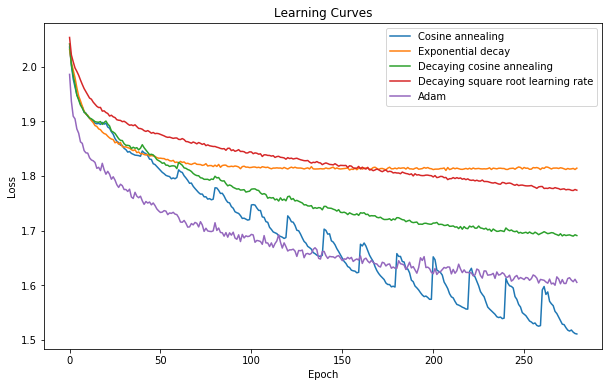

In [11]:
plt.figure(figsize = (10,6))
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
data = [('Cosine annealing', history_list_FFNN[0]), ('Exponential decay', history_list_FFNN[1]),('Decaying cosine annealing', history_list_FFNN[2]), 
        ('Decaying square root learning rate', history_list_FFNN[3]), ('Adam', history_list_FFNN[4])]
for i in data:
    plt.plot(i[1].history['loss'], label=i[0])
plt.legend()
plt.show()

From the graph above we can see that the cosine annealing learning rate schedule performs the best, this is likely due to the high periodic learning rate overcoming local minima. We will use this for our first candidate model.
## Model 1

In [8]:
model_FFNN = keras.Sequential([
        layers.Flatten(),
        layers.Dense(units=256, activation='relu'),
        layers.Dropout(0.15),
        layers.Dense(units=128, activation='relu'),
        layers.Dropout(0.15),
        layers.Dense(units=64, activation='relu'),
        layers.Dropout(0.15),
        layers.Dense(units=32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(units=8, activation='softmax')
    ])
model_FFNN.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD'),
                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(3)])

history_FFNN = model_FFNN.fit(X_train, Y_train, epochs=300, batch_size=250, validation_data=(X_test, Y_test), shuffle = True, 
                              callbacks = [cos_lr])

Train on 19182 samples, validate on 1600 samples
Epoch 1/300
19182/19182 [==============================] - 1s 74us/sample - loss: 2.0468 - accuracy: 0.1976 - top_k_categorical_accuracy: 0.4577 - val_loss: 2.0431 - val_accuracy: 0.1937 - val_top_k_categorical_accuracy: 0.4700
Epoch 2/300
19182/19182 [==============================] - 1s 29us/sample - loss: 2.0156 - accuracy: 0.2405 - top_k_categorical_accuracy: 0.5032 - val_loss: 2.0255 - val_accuracy: 0.2262 - val_top_k_categorical_accuracy: 0.5013
Epoch 3/300
19182/19182 [==============================] - 1s 30us/sample - loss: 1.9927 - accuracy: 0.2684 - top_k_categorical_accuracy: 0.5296 - val_loss: 2.0024 - val_accuracy: 0.2688 - val_top_k_categorical_accuracy: 0.5650
Epoch 4/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.9739 - accuracy: 0.2858 - top_k_categorical_accuracy: 0.5553 - val_loss: 1.9917 - val_accuracy: 0.2713 - val_top_k_categorical_accuracy: 0.5387
Epoch 5/300
19182/19182 [==============

19182/19182 [==============================] - 1s 29us/sample - loss: 1.8645 - accuracy: 0.4086 - top_k_categorical_accuracy: 0.6381 - val_loss: 1.9455 - val_accuracy: 0.3200 - val_top_k_categorical_accuracy: 0.5562
Epoch 37/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8660 - accuracy: 0.4056 - top_k_categorical_accuracy: 0.6428 - val_loss: 1.9446 - val_accuracy: 0.3162 - val_top_k_categorical_accuracy: 0.5587
Epoch 38/300
19182/19182 [==============================] - 1s 28us/sample - loss: 1.8649 - accuracy: 0.4059 - top_k_categorical_accuracy: 0.6409 - val_loss: 1.9448 - val_accuracy: 0.3200 - val_top_k_categorical_accuracy: 0.5537
Epoch 39/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8643 - accuracy: 0.4075 - top_k_categorical_accuracy: 0.6405 - val_loss: 1.9456 - val_accuracy: 0.3200 - val_top_k_categorical_accuracy: 0.5562
Epoch 40/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.8628 - accur

Epoch 72/300
19182/19182 [==============================] - 1s 32us/sample - loss: 1.8021 - accuracy: 0.4702 - top_k_categorical_accuracy: 0.6875 - val_loss: 1.9445 - val_accuracy: 0.3150 - val_top_k_categorical_accuracy: 0.5950
Epoch 73/300
19182/19182 [==============================] - 1s 30us/sample - loss: 1.7995 - accuracy: 0.4747 - top_k_categorical_accuracy: 0.6888 - val_loss: 1.9475 - val_accuracy: 0.3262 - val_top_k_categorical_accuracy: 0.5825
Epoch 74/300
19182/19182 [==============================] - 1s 30us/sample - loss: 1.7965 - accuracy: 0.4796 - top_k_categorical_accuracy: 0.6911 - val_loss: 1.9446 - val_accuracy: 0.3200 - val_top_k_categorical_accuracy: 0.5850
Epoch 75/300
19182/19182 [==============================] - 1s 30us/sample - loss: 1.7942 - accuracy: 0.4827 - top_k_categorical_accuracy: 0.6936 - val_loss: 1.9483 - val_accuracy: 0.3150 - val_top_k_categorical_accuracy: 0.5900
Epoch 76/300
19182/19182 [==============================] - 1s 30us/sample - loss: 1

Epoch 108/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.7326 - accuracy: 0.5442 - top_k_categorical_accuracy: 0.7733 - val_loss: 1.9435 - val_accuracy: 0.3137 - val_top_k_categorical_accuracy: 0.6300
Epoch 109/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.7290 - accuracy: 0.5476 - top_k_categorical_accuracy: 0.7744 - val_loss: 1.9338 - val_accuracy: 0.3162 - val_top_k_categorical_accuracy: 0.6488
Epoch 110/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.7230 - accuracy: 0.5532 - top_k_categorical_accuracy: 0.7737 - val_loss: 1.9280 - val_accuracy: 0.3363 - val_top_k_categorical_accuracy: 0.6513
Epoch 111/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.7181 - accuracy: 0.5600 - top_k_categorical_accuracy: 0.7799 - val_loss: 1.9272 - val_accuracy: 0.3350 - val_top_k_categorical_accuracy: 0.6500
Epoch 112/300
19182/19182 [==============================] - 1s 29us/sample - lo

Epoch 144/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6975 - accuracy: 0.5784 - top_k_categorical_accuracy: 0.7917 - val_loss: 1.9342 - val_accuracy: 0.3212 - val_top_k_categorical_accuracy: 0.6375
Epoch 145/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6963 - accuracy: 0.5799 - top_k_categorical_accuracy: 0.7899 - val_loss: 1.9264 - val_accuracy: 0.3413 - val_top_k_categorical_accuracy: 0.6388
Epoch 146/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6887 - accuracy: 0.5891 - top_k_categorical_accuracy: 0.7923 - val_loss: 1.9240 - val_accuracy: 0.3450 - val_top_k_categorical_accuracy: 0.6488
Epoch 147/300
19182/19182 [==============================] - 1s 28us/sample - loss: 1.6828 - accuracy: 0.5940 - top_k_categorical_accuracy: 0.7945 - val_loss: 1.9314 - val_accuracy: 0.3325 - val_top_k_categorical_accuracy: 0.6225
Epoch 148/300
19182/19182 [==============================] - 1s 29us/sample - lo

Epoch 180/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6082 - accuracy: 0.6714 - top_k_categorical_accuracy: 0.8208 - val_loss: 1.9243 - val_accuracy: 0.3487 - val_top_k_categorical_accuracy: 0.6350
Epoch 181/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6622 - accuracy: 0.6142 - top_k_categorical_accuracy: 0.8071 - val_loss: 1.9223 - val_accuracy: 0.3413 - val_top_k_categorical_accuracy: 0.6500
Epoch 182/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6629 - accuracy: 0.6142 - top_k_categorical_accuracy: 0.8042 - val_loss: 1.9250 - val_accuracy: 0.3363 - val_top_k_categorical_accuracy: 0.6413
Epoch 183/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.6651 - accuracy: 0.6112 - top_k_categorical_accuracy: 0.8067 - val_loss: 1.9241 - val_accuracy: 0.3462 - val_top_k_categorical_accuracy: 0.6137
Epoch 184/300
19182/19182 [==============================] - 1s 29us/sample - lo

Epoch 216/300
19182/19182 [==============================] - 1s 28us/sample - loss: 1.5691 - accuracy: 0.7109 - top_k_categorical_accuracy: 0.8349 - val_loss: 1.9280 - val_accuracy: 0.3388 - val_top_k_categorical_accuracy: 0.6263
Epoch 217/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.5663 - accuracy: 0.7137 - top_k_categorical_accuracy: 0.8370 - val_loss: 1.9257 - val_accuracy: 0.3413 - val_top_k_categorical_accuracy: 0.6263
Epoch 218/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.5649 - accuracy: 0.7146 - top_k_categorical_accuracy: 0.8372 - val_loss: 1.9243 - val_accuracy: 0.3425 - val_top_k_categorical_accuracy: 0.6237
Epoch 219/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.5635 - accuracy: 0.7152 - top_k_categorical_accuracy: 0.8351 - val_loss: 1.9208 - val_accuracy: 0.3438 - val_top_k_categorical_accuracy: 0.6237
Epoch 220/300
19182/19182 [==============================] - 1s 29us/sample - lo

Epoch 252/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.5509 - accuracy: 0.7261 - top_k_categorical_accuracy: 0.8453 - val_loss: 1.9240 - val_accuracy: 0.3462 - val_top_k_categorical_accuracy: 0.6375
Epoch 253/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.5439 - accuracy: 0.7334 - top_k_categorical_accuracy: 0.8450 - val_loss: 1.9311 - val_accuracy: 0.3375 - val_top_k_categorical_accuracy: 0.6300
Epoch 254/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.5414 - accuracy: 0.7364 - top_k_categorical_accuracy: 0.8463 - val_loss: 1.9273 - val_accuracy: 0.3400 - val_top_k_categorical_accuracy: 0.6250
Epoch 255/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.5374 - accuracy: 0.7398 - top_k_categorical_accuracy: 0.8486 - val_loss: 1.9260 - val_accuracy: 0.3462 - val_top_k_categorical_accuracy: 0.6263
Epoch 256/300
19182/19182 [==============================] - 1s 29us/sample - lo

Epoch 288/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.5512 - accuracy: 0.7261 - top_k_categorical_accuracy: 0.8491 - val_loss: 1.9560 - val_accuracy: 0.3100 - val_top_k_categorical_accuracy: 0.6125
Epoch 289/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.5365 - accuracy: 0.7411 - top_k_categorical_accuracy: 0.8529 - val_loss: 1.9257 - val_accuracy: 0.3413 - val_top_k_categorical_accuracy: 0.6225
Epoch 290/300
19182/19182 [==============================] - 1s 27us/sample - loss: 1.5361 - accuracy: 0.7410 - top_k_categorical_accuracy: 0.8525 - val_loss: 1.9370 - val_accuracy: 0.3288 - val_top_k_categorical_accuracy: 0.6237
Epoch 291/300
19182/19182 [==============================] - 1s 29us/sample - loss: 1.5262 - accuracy: 0.7509 - top_k_categorical_accuracy: 0.8537 - val_loss: 1.9277 - val_accuracy: 0.3338 - val_top_k_categorical_accuracy: 0.6375
Epoch 292/300
19182/19182 [==============================] - 1s 29us/sample - lo

In [9]:
model_FFNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1048832   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  32896     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  8256      
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0

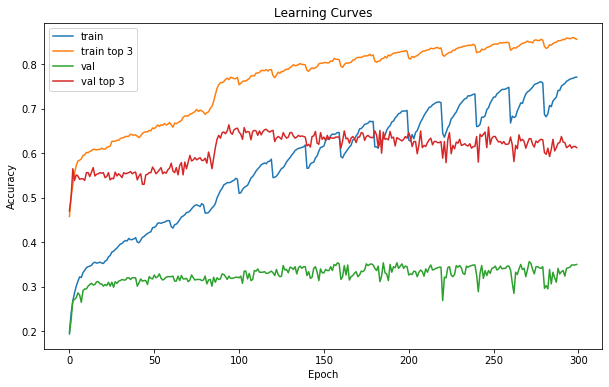

In [10]:
plt.figure(figsize = (10,6))
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history_FFNN.history['accuracy'], label='train')
plt.plot(history_FFNN.history['top_k_categorical_accuracy'], label='train top 3')
plt.plot(history_FFNN.history['val_accuracy'], label='val')
plt.plot(history_FFNN.history['val_top_k_categorical_accuracy'], label='val top 3')
plt.legend()
plt.show()

We stop the training here as validation accuracy was not improving. Interestingly we observe periodic spikes in our training accuracy. These spikes correspond to points where our learning rate shows a sharp increase (i.e. every 20 epochs).

## Comparing various optimisers with our second model
Our second model will be a three-layer convolution neural-network with an extra hidden layer.

## Optimisers

### Stochastic Gradient Descent
Gradient descent is an iterative algorithm, that starts from a random point on a function and travels down its slope in steps until it reaches the lowest point of that function (i.e. where the gradient = 0). Standard gradient descent uses the sum of squared residuals when calculating the gradient and this consists of as many terms as there are data points. To reduce computation SGD randomly picks one data point, or a sample of data points at each iteration to estimate the gradient. We can accelerate this learning using momentum by also taking into account the gradient of the previous time steps. Nesterov Accelerated Gradient Descent "looks ahead", we can partially update the current gradient and peek ahead to the next update. Nesterov Accelerated Gradients help prevent larger oscillations in comparison to using standard Momentum. For this example, we will use SGD with Nesterov's momentum.

### RMSprop 
This is another adaptive learning rate algorithms, it is very similar to Adagrad. Adagrad keeps a historical running sum of squared gradients, and the new learning rate is inversely proportional to the square root of that gradient. RMSprop tries to slow down the rate at which Adagrad diminishes the gradient by using a moving average of the squared gradients $g_{t-1}^2$. 
$g_t$ is the current gradient and $\gamma$ is a parameter to be chosen between 0 and 1. The equation for each update is shown below. Also, a different learning rate is chosen for each parameter.

$$ w_{t+1} = w_t - \frac{ \eta * g_t }{\sqrt{ g_{t-1}^2(1-\gamma) + g_t\gamma + \epsilon}}$$

### Adam
Adaptive Moment Estimation - it calculates the individual adaptive learning rate for each parameter from estimates of the first and second moments of the gradients. It reduces the radically diminishing learning rates of Adagrad by keeping an exponentially decaying average of past gradients rather than a simple average. Here each update is proportional to the average gradient/ sqr(average gradient norm).

### Nadam
Nesterov-accelerated Adaptive Moment Estimation [5] - This is typically used for noisy gradients or gradients with high curvatures. The learning process is accelerated by summing up the exponential decay of the moving averages for the current and previous gradients.

In [11]:
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0, epsilon=1e-07)
adam = optimizer=tf.keras.optimizers.Adam(0.001)
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
nadam = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
optimisers = [rmsprop, adam, sgd, nadam]

In [14]:
history_list = []
for opt in optimisers:
    model_CNN = keras.Sequential([
        layers.Reshape(target_shape=(64, 64, 1), input_shape=(64, 64)),
        layers.Conv2D(filters = 16, kernel_size  =  2, activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), padding='same'),
        layers.Dropout(0.3),
        layers.Conv2D(filters = 32, kernel_size  =  2, activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), padding='same'),
        layers.Dropout(0.3),
        layers.Conv2D(filters = 64, kernel_size  =  2, activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), padding='same'),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(units=1000, activation='relu'),
        layers.Dense(units=8, activation='softmax')
    ])
    model_CNN.compile(optimizer=opt,
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    history_CNN = model_CNN.fit(X_train, Y_train, epochs=120, batch_size=128, validation_data=(X_test, Y_test), shuffle = True)
    history_list.append(history_CNN)

Train on 19182 samples, validate on 1600 samples
Epoch 1/120
19182/19182 [==============================] - 3s 155us/sample - loss: 1.9999 - accuracy: 0.2570 - val_loss: 1.9877 - val_accuracy: 0.2788
Epoch 2/120
19182/19182 [==============================] - 2s 115us/sample - loss: 1.9000 - accuracy: 0.3623 - val_loss: 1.9596 - val_accuracy: 0.3050
Epoch 3/120
19182/19182 [==============================] - 2s 115us/sample - loss: 1.8636 - accuracy: 0.4012 - val_loss: 1.9336 - val_accuracy: 0.3363
Epoch 4/120
19182/19182 [==============================] - 2s 116us/sample - loss: 1.8463 - accuracy: 0.4204 - val_loss: 1.9425 - val_accuracy: 0.3225
Epoch 5/120
19182/19182 [==============================] - 2s 117us/sample - loss: 1.8321 - accuracy: 0.4353 - val_loss: 1.9364 - val_accuracy: 0.3237
Epoch 6/120
19182/19182 [==============================] - 2s 115us/sample - loss: 1.8229 - accuracy: 0.4442 - val_loss: 1.9457 - val_accuracy: 0.3212
Epoch 7/120
19182/19182 [====================

Epoch 108/120
19182/19182 [==============================] - 2s 116us/sample - loss: 1.4700 - accuracy: 0.8032 - val_loss: 1.8761 - val_accuracy: 0.3950
Epoch 109/120
19182/19182 [==============================] - 2s 116us/sample - loss: 1.4719 - accuracy: 0.8017 - val_loss: 1.8778 - val_accuracy: 0.3887
Epoch 110/120
19182/19182 [==============================] - 2s 115us/sample - loss: 1.4659 - accuracy: 0.8082 - val_loss: 1.8789 - val_accuracy: 0.3950
Epoch 111/120
19182/19182 [==============================] - 2s 116us/sample - loss: 1.4652 - accuracy: 0.8087 - val_loss: 1.8705 - val_accuracy: 0.4013
Epoch 112/120
19182/19182 [==============================] - 2s 115us/sample - loss: 1.4678 - accuracy: 0.8055 - val_loss: 1.8491 - val_accuracy: 0.4200
Epoch 113/120
19182/19182 [==============================] - 2s 117us/sample - loss: 1.4654 - accuracy: 0.8078 - val_loss: 1.8737 - val_accuracy: 0.3938
Epoch 114/120
19182/19182 [==============================] - 2s 116us/sample - los

Epoch 95/120
19182/19182 [==============================] - 2s 108us/sample - loss: 1.4578 - accuracy: 0.8158 - val_loss: 1.8855 - val_accuracy: 0.3825
Epoch 96/120
19182/19182 [==============================] - 2s 108us/sample - loss: 1.4547 - accuracy: 0.8198 - val_loss: 1.8684 - val_accuracy: 0.3950
Epoch 97/120
19182/19182 [==============================] - 2s 107us/sample - loss: 1.4516 - accuracy: 0.8233 - val_loss: 1.8475 - val_accuracy: 0.4175
Epoch 98/120
19182/19182 [==============================] - 2s 108us/sample - loss: 1.4546 - accuracy: 0.8197 - val_loss: 1.8640 - val_accuracy: 0.4038
Epoch 99/120
19182/19182 [==============================] - 2s 107us/sample - loss: 1.4506 - accuracy: 0.8244 - val_loss: 1.8681 - val_accuracy: 0.4025
Epoch 100/120
19182/19182 [==============================] - 2s 107us/sample - loss: 1.4540 - accuracy: 0.8205 - val_loss: 1.8642 - val_accuracy: 0.4038
Epoch 101/120
19182/19182 [==============================] - 2s 107us/sample - loss: 1.

Epoch 82/120
19182/19182 [==============================] - 2s 107us/sample - loss: 1.6673 - accuracy: 0.6066 - val_loss: 1.8543 - val_accuracy: 0.4025
Epoch 83/120
19182/19182 [==============================] - 2s 108us/sample - loss: 1.6639 - accuracy: 0.6098 - val_loss: 1.8346 - val_accuracy: 0.4425
Epoch 84/120
19182/19182 [==============================] - 2s 107us/sample - loss: 1.6635 - accuracy: 0.6098 - val_loss: 1.8549 - val_accuracy: 0.4125
Epoch 85/120
19182/19182 [==============================] - 2s 106us/sample - loss: 1.6637 - accuracy: 0.6104 - val_loss: 1.8515 - val_accuracy: 0.4150
Epoch 86/120
19182/19182 [==============================] - 2s 107us/sample - loss: 1.6617 - accuracy: 0.6119 - val_loss: 1.8465 - val_accuracy: 0.4137
Epoch 87/120
19182/19182 [==============================] - 2s 106us/sample - loss: 1.6632 - accuracy: 0.6095 - val_loss: 1.8425 - val_accuracy: 0.4112
Epoch 88/120
19182/19182 [==============================] - 2s 107us/sample - loss: 1.65

Epoch 69/120
19182/19182 [==============================] - 2s 127us/sample - loss: 1.4844 - accuracy: 0.7912 - val_loss: 1.8681 - val_accuracy: 0.4013
Epoch 70/120
19182/19182 [==============================] - 2s 127us/sample - loss: 1.4780 - accuracy: 0.7976 - val_loss: 1.8817 - val_accuracy: 0.3825
Epoch 71/120
19182/19182 [==============================] - 2s 126us/sample - loss: 1.4782 - accuracy: 0.7976 - val_loss: 1.8629 - val_accuracy: 0.4087
Epoch 72/120
19182/19182 [==============================] - 2s 126us/sample - loss: 1.4770 - accuracy: 0.7989 - val_loss: 1.8726 - val_accuracy: 0.3900
Epoch 73/120
19182/19182 [==============================] - 2s 126us/sample - loss: 1.4760 - accuracy: 0.7992 - val_loss: 1.8762 - val_accuracy: 0.3850
Epoch 74/120
19182/19182 [==============================] - 2s 126us/sample - loss: 1.4703 - accuracy: 0.8055 - val_loss: 1.8705 - val_accuracy: 0.3975
Epoch 75/120
19182/19182 [==============================] - 2s 126us/sample - loss: 1.47

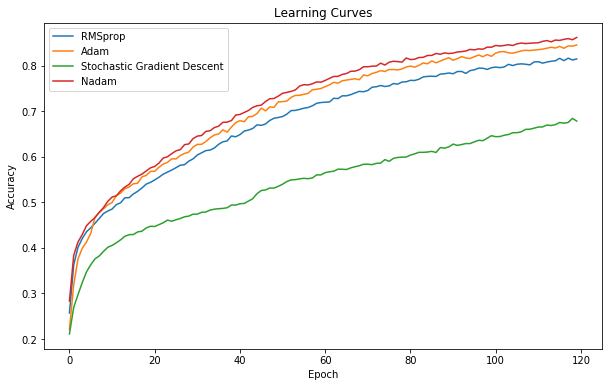

In [15]:
plt.figure(figsize = (10,6))
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
data = [("RMSprop", history_list[0]), ("Adam", history_list[1]),("Stochastic Gradient Descent", history_list[2]), ("Nadam", history_list[3])]
for i in data:
    plt.plot(i[1].history['accuracy'], label=i[0])
plt.legend()
plt.show()

From the graph above we can see that the Nadam optimiser performs the best, we will use this for our second candidate model. I also tried some of the custom learning rates shown for model 1 but they had a poor performance for this CNN model.

## Model 2

In [12]:
model_CNN = keras.Sequential([
    layers.Reshape(target_shape=(64, 64, 1), input_shape=(64, 64)),
    layers.Conv2D(filters = 16, kernel_size  =  2, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=(2, 2), padding='same'),
    layers.Dropout(0.3),
    layers.Conv2D(filters = 32, kernel_size  =  2, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=(2, 2), padding='same'),
    layers.Dropout(0.3),
    layers.Conv2D(filters = 64, kernel_size  =  2, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=(2, 2), padding='same'),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(units=1000, activation='relu'),
    layers.Dense(units=8, activation='softmax')
])
model_CNN.compile(optimizer=nadam,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(3)])
history_CNN = model_CNN.fit(X_train, Y_train, epochs=140, batch_size=128, validation_data=(X_test, Y_test), shuffle = True)

Train on 19182 samples, validate on 1600 samples
Epoch 1/140
19182/19182 [==============================] - 4s 231us/sample - loss: 1.9889 - accuracy: 0.2660 - top_k_categorical_accuracy: 0.5551 - val_loss: 1.9866 - val_accuracy: 0.2612 - val_top_k_categorical_accuracy: 0.6187
Epoch 2/140
19182/19182 [==============================] - 2s 130us/sample - loss: 1.8719 - accuracy: 0.3937 - top_k_categorical_accuracy: 0.7199 - val_loss: 1.9592 - val_accuracy: 0.3025 - val_top_k_categorical_accuracy: 0.6363
Epoch 3/140
19182/19182 [==============================] - 3s 131us/sample - loss: 1.8439 - accuracy: 0.4218 - top_k_categorical_accuracy: 0.7378 - val_loss: 1.9344 - val_accuracy: 0.3150 - val_top_k_categorical_accuracy: 0.6750
Epoch 4/140
19182/19182 [==============================] - 2s 130us/sample - loss: 1.8236 - accuracy: 0.4430 - top_k_categorical_accuracy: 0.7486 - val_loss: 1.9418 - val_accuracy: 0.3038 - val_top_k_categorical_accuracy: 0.6900
Epoch 5/140
19182/19182 [==========

19182/19182 [==============================] - 2s 130us/sample - loss: 1.6003 - accuracy: 0.6749 - top_k_categorical_accuracy: 0.8475 - val_loss: 1.8484 - val_accuracy: 0.4175 - val_top_k_categorical_accuracy: 0.7412
Epoch 37/140
19182/19182 [==============================] - 2s 130us/sample - loss: 1.5976 - accuracy: 0.6783 - top_k_categorical_accuracy: 0.8484 - val_loss: 1.8600 - val_accuracy: 0.4137 - val_top_k_categorical_accuracy: 0.7450
Epoch 38/140
19182/19182 [==============================] - 3s 132us/sample - loss: 1.5922 - accuracy: 0.6822 - top_k_categorical_accuracy: 0.8506 - val_loss: 1.8301 - val_accuracy: 0.4350 - val_top_k_categorical_accuracy: 0.7475
Epoch 39/140
19182/19182 [==============================] - 3s 135us/sample - loss: 1.5870 - accuracy: 0.6894 - top_k_categorical_accuracy: 0.8520 - val_loss: 1.8494 - val_accuracy: 0.4200 - val_top_k_categorical_accuracy: 0.7525
Epoch 40/140
19182/19182 [==============================] - 3s 132us/sample - loss: 1.5851 - 

Epoch 72/140
19182/19182 [==============================] - 2s 130us/sample - loss: 1.4833 - accuracy: 0.7931 - top_k_categorical_accuracy: 0.8914 - val_loss: 1.8605 - val_accuracy: 0.4087 - val_top_k_categorical_accuracy: 0.7437
Epoch 73/140
19182/19182 [==============================] - 2s 130us/sample - loss: 1.4792 - accuracy: 0.7961 - top_k_categorical_accuracy: 0.8929 - val_loss: 1.8587 - val_accuracy: 0.4087 - val_top_k_categorical_accuracy: 0.7538
Epoch 74/140
19182/19182 [==============================] - 3s 131us/sample - loss: 1.4828 - accuracy: 0.7918 - top_k_categorical_accuracy: 0.8929 - val_loss: 1.8576 - val_accuracy: 0.4100 - val_top_k_categorical_accuracy: 0.7538
Epoch 75/140
19182/19182 [==============================] - 2s 130us/sample - loss: 1.4754 - accuracy: 0.8003 - top_k_categorical_accuracy: 0.8946 - val_loss: 1.8519 - val_accuracy: 0.4137 - val_top_k_categorical_accuracy: 0.7575
Epoch 76/140
19182/19182 [==============================] - 3s 132us/sample - lo

19182/19182 [==============================] - 3s 131us/sample - loss: 1.4323 - accuracy: 0.8421 - top_k_categorical_accuracy: 0.9123 - val_loss: 1.8851 - val_accuracy: 0.3837 - val_top_k_categorical_accuracy: 0.7525
Epoch 108/140
19182/19182 [==============================] - 3s 131us/sample - loss: 1.4318 - accuracy: 0.8417 - top_k_categorical_accuracy: 0.9146 - val_loss: 1.8678 - val_accuracy: 0.4038 - val_top_k_categorical_accuracy: 0.7150
Epoch 109/140
19182/19182 [==============================] - 3s 131us/sample - loss: 1.4306 - accuracy: 0.8446 - top_k_categorical_accuracy: 0.9150 - val_loss: 1.8813 - val_accuracy: 0.3850 - val_top_k_categorical_accuracy: 0.7287
Epoch 110/140
19182/19182 [==============================] - 3s 131us/sample - loss: 1.4303 - accuracy: 0.8433 - top_k_categorical_accuracy: 0.9148 - val_loss: 1.8583 - val_accuracy: 0.4100 - val_top_k_categorical_accuracy: 0.7425
Epoch 111/140
19182/19182 [==============================] - 3s 130us/sample - loss: 1.432

In [13]:
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)       

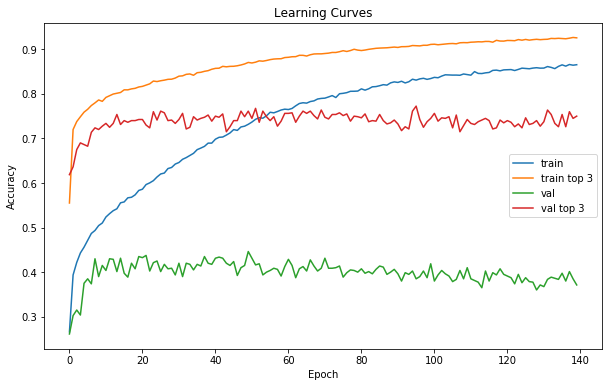

In [14]:
plt.figure(figsize = (10,6))
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history_CNN.history['accuracy'], label='train')
plt.plot(history_CNN.history['top_k_categorical_accuracy'], label='train top 3')
plt.plot(history_CNN.history['val_accuracy'], label='val')
plt.plot(history_CNN.history['val_top_k_categorical_accuracy'], label='val top 3')
plt.legend()
plt.show()

We stop training here because validation accuracy was not improving and training loss was levelling off.

### Observing the effect of other callbacks on model 3.

A spectrogram is a visual representation of audio across frequency and time. While CNN's do a great job for image recognition, there is also a time aspect to the song and RNNs can do a much better job of identifying the short term and long term temporal features of each track. Therefore our third model is a Convolutional Recurrent Model. This architecture was inspired by resource [6].

Here we also wish to look at the effects of the ReduceLROnPlateau callback, which reduces the learning rate when validation accuracy starts to plateau. Along with the ModelCheckpoint callback which goes back to the weights of the best model in terms of validation accuracy, if the accuracy starts to decrease.

In [10]:
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor = 0.5, patience = 5, cooldown = 5, verbose=1)
checkpoint_LSTM = tf.keras.callbacks.ModelCheckpoint('./Models/model_LSTM/weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode='max')

In [12]:
history_list_CRNN = []
for i in range(3):
    model_CRNN = keras.Sequential([

        layers.Conv1D(filters = 64, kernel_size =  5, activation='relu', padding='valid'),
        layers.BatchNormalization(momentum=0.9),
        layers.MaxPool1D(pool_size=(2), padding='same'),
        layers.Dropout(0.4),
        layers.Conv1D(filters = 64, kernel_size  =  5, activation='relu', padding='valid'),
        layers.BatchNormalization(momentum=0.9),
        layers.MaxPool1D(pool_size=(2), padding='same'),
        layers.Dropout(0.4),
        layers.Conv1D(filters = 64, kernel_size  =  5, activation='relu', padding='valid'),
        layers.BatchNormalization(momentum=0.9),
        layers.MaxPool1D(pool_size=(2), padding='same'),
        layers.Dropout(0.3),
        layers.LSTM(units=100),
        layers.Dense(units=64, activation='relu'),
        layers.Dense(units=8, activation='softmax')
    ])
    model_CRNN.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    if i == 0:
        history_CRNN = model_CRNN.fit(X_train, Y_train, epochs=140, batch_size=128, validation_data=(X_test, Y_test), shuffle = True)
    elif i == 1:
        history_CRNN = model_CRNN.fit(X_train, Y_train, epochs=140, batch_size=128, validation_data=(X_test, Y_test), 
                                      shuffle = True, callbacks = [reducelr])
    else:
        history_CRNN = model_CRNN.fit(X_train, Y_train, epochs=140, batch_size=128, validation_data=(X_test, Y_test), 
                                      shuffle = True, callbacks = [checkpoint_LSTM])
    history_list_CRNN.append(history_CRNN)

Train on 19182 samples, validate on 1600 samples
Epoch 1/140
19182/19182 [==============================] - 5s 275us/sample - loss: 1.9669 - accuracy: 0.2928 - val_loss: 2.0249 - val_accuracy: 0.2212
Epoch 2/140
19182/19182 [==============================] - 2s 83us/sample - loss: 1.9341 - accuracy: 0.3260 - val_loss: 1.9746 - val_accuracy: 0.2937
Epoch 3/140
19182/19182 [==============================] - 2s 82us/sample - loss: 1.9153 - accuracy: 0.3469 - val_loss: 1.9510 - val_accuracy: 0.3150
Epoch 4/140
19182/19182 [==============================] - 2s 83us/sample - loss: 1.9012 - accuracy: 0.3620 - val_loss: 1.9263 - val_accuracy: 0.3250
Epoch 5/140
19182/19182 [==============================] - 2s 82us/sample - loss: 1.8892 - accuracy: 0.3756 - val_loss: 1.9426 - val_accuracy: 0.3150
Epoch 6/140
19182/19182 [==============================] - 2s 82us/sample - loss: 1.8785 - accuracy: 0.3870 - val_loss: 1.9382 - val_accuracy: 0.3225
Epoch 7/140
19182/19182 [=========================

Epoch 55/140
19182/19182 [==============================] - 2s 83us/sample - loss: 1.7624 - accuracy: 0.5074 - val_loss: 1.9315 - val_accuracy: 0.3313
Epoch 56/140
19182/19182 [==============================] - 2s 83us/sample - loss: 1.7609 - accuracy: 0.5105 - val_loss: 1.9353 - val_accuracy: 0.3313
Epoch 57/140
19182/19182 [==============================] - 2s 81us/sample - loss: 1.7623 - accuracy: 0.5082 - val_loss: 1.9274 - val_accuracy: 0.3388
Epoch 58/140
19182/19182 [==============================] - 2s 83us/sample - loss: 1.7623 - accuracy: 0.5063 - val_loss: 1.9287 - val_accuracy: 0.3388
Epoch 59/140
19182/19182 [==============================] - 2s 84us/sample - loss: 1.7645 - accuracy: 0.5055 - val_loss: 1.9418 - val_accuracy: 0.3250
Epoch 60/140
19182/19182 [==============================] - 2s 82us/sample - loss: 1.7570 - accuracy: 0.5126 - val_loss: 1.9448 - val_accuracy: 0.3187
Epoch 61/140
19182/19182 [==============================] - 2s 83us/sample - loss: 1.7611 - ac

Epoch 21/140
19182/19182 [==============================] - 2s 81us/sample - loss: 1.8035 - accuracy: 0.4651 - val_loss: 1.9315 - val_accuracy: 0.3288
Epoch 22/140
19182/19182 [==============================] - 2s 84us/sample - loss: 1.7966 - accuracy: 0.4737 - val_loss: 1.9305 - val_accuracy: 0.3237
Epoch 23/140
19182/19182 [==============================] - 2s 80us/sample - loss: 1.7959 - accuracy: 0.4740 - val_loss: 1.9350 - val_accuracy: 0.3338
Epoch 24/140
19182/19182 [==============================] - 2s 81us/sample - loss: 1.7946 - accuracy: 0.4760 - val_loss: 1.9279 - val_accuracy: 0.3375
Epoch 25/140
19182/19182 [==============================] - 2s 83us/sample - loss: 1.7904 - accuracy: 0.4788 - val_loss: 1.9313 - val_accuracy: 0.3313
Epoch 26/140
19182/19182 [==============================] - 2s 81us/sample - loss: 1.7928 - accuracy: 0.4757 - val_loss: 1.9337 - val_accuracy: 0.3300
Epoch 27/140
19182/19182 [==============================] - 2s 83us/sample - loss: 1.7878 - ac

19182/19182 [==============================] - 2s 82us/sample - loss: 1.7561 - accuracy: 0.5154 - val_loss: 1.9249 - val_accuracy: 0.3413
Epoch 118/140
19182/19182 [==============================] - 2s 82us/sample - loss: 1.7584 - accuracy: 0.5129 - val_loss: 1.9243 - val_accuracy: 0.3388
Epoch 119/140
18560/19182 [============================>.] - ETA: 0s - loss: 1.7553 - accuracy: 0.5161
Epoch 00119: ReduceLROnPlateau reducing learning rate to 3.6621094068323146e-07.
19182/19182 [==============================] - 2s 82us/sample - loss: 1.7558 - accuracy: 0.5153 - val_loss: 1.9240 - val_accuracy: 0.3438
Epoch 120/140
19182/19182 [==============================] - 2s 82us/sample - loss: 1.7588 - accuracy: 0.5113 - val_loss: 1.9255 - val_accuracy: 0.3462
Epoch 121/140
19182/19182 [==============================] - 2s 84us/sample - loss: 1.7583 - accuracy: 0.5132 - val_loss: 1.9257 - val_accuracy: 0.3375
Epoch 122/140
19182/19182 [==============================] - 2s 82us/sample - loss: 

Epoch 14/140
18816/19182 [============================>.] - ETA: 0s - loss: 1.8413 - accuracy: 0.4261
Epoch 00014: val_accuracy did not improve from 0.32750
19182/19182 [==============================] - 2s 86us/sample - loss: 1.8419 - accuracy: 0.4253 - val_loss: 1.9527 - val_accuracy: 0.3100
Epoch 15/140
18560/19182 [============================>.] - ETA: 0s - loss: 1.8408 - accuracy: 0.4260
Epoch 00015: val_accuracy did not improve from 0.32750
19182/19182 [==============================] - 2s 83us/sample - loss: 1.8408 - accuracy: 0.4259 - val_loss: 1.9553 - val_accuracy: 0.3050
Epoch 16/140
18944/19182 [============================>.] - ETA: 0s - loss: 1.8383 - accuracy: 0.4281 ETA: 0s - loss: 1.8369 
Epoch 00016: val_accuracy improved from 0.32750 to 0.33875, saving model to ./Models/model_LSTM/weights.hdf5
19182/19182 [==============================] - 2s 86us/sample - loss: 1.8381 - accuracy: 0.4283 - val_loss: 1.9243 - val_accuracy: 0.3388
Epoch 17/140
18688/19182 [===========

Epoch 69/140
18688/19182 [============================>.] - ETA: 0s - loss: 1.7539 - accuracy: 0.5165
Epoch 00069: val_accuracy did not improve from 0.36500
19182/19182 [==============================] - 2s 83us/sample - loss: 1.7540 - accuracy: 0.5163 - val_loss: 1.9308 - val_accuracy: 0.3300
Epoch 70/140
18560/19182 [============================>.] - ETA: 0s - loss: 1.7520 - accuracy: 0.5186
Epoch 00070: val_accuracy did not improve from 0.36500
19182/19182 [==============================] - 2s 84us/sample - loss: 1.7531 - accuracy: 0.5174 - val_loss: 1.9266 - val_accuracy: 0.3462
Epoch 71/140
19072/19182 [============================>.] - ETA: 0s - loss: 1.7505 - accuracy: 0.5211
Epoch 00071: val_accuracy did not improve from 0.36500
19182/19182 [==============================] - 2s 84us/sample - loss: 1.7506 - accuracy: 0.5209 - val_loss: 1.9423 - val_accuracy: 0.3262
Epoch 72/140
18688/19182 [============================>.] - ETA: 0s - loss: 1.7524 - accuracy: 0.5172
Epoch 00072: 

Epoch 97/140
18816/19182 [============================>.] - ETA: 0s - loss: 1.7315 - accuracy: 0.5397
Epoch 00097: val_accuracy did not improve from 0.36500
19182/19182 [==============================] - 2s 83us/sample - loss: 1.7315 - accuracy: 0.5398 - val_loss: 1.9085 - val_accuracy: 0.3613
Epoch 98/140
18688/19182 [============================>.] - ETA: 0s - loss: 1.7317 - accuracy: 0.5387
Epoch 00098: val_accuracy did not improve from 0.36500
19182/19182 [==============================] - 2s 82us/sample - loss: 1.7324 - accuracy: 0.5379 - val_loss: 1.9198 - val_accuracy: 0.3462
Epoch 99/140
18432/19182 [===========================>..] - ETA: 0s - loss: 1.7311 - accuracy: 0.5390
Epoch 00099: val_accuracy did not improve from 0.36500
19182/19182 [==============================] - 2s 82us/sample - loss: 1.7313 - accuracy: 0.5390 - val_loss: 1.9303 - val_accuracy: 0.3313
Epoch 100/140
18432/19182 [===========================>..] - ETA: 0s - loss: 1.7327 - accuracy: 0.5378
Epoch 00100:

Epoch 125/140
18688/19182 [============================>.] - ETA: 0s - loss: 1.7186 - accuracy: 0.5524
Epoch 00125: val_accuracy did not improve from 0.36500
19182/19182 [==============================] - 2s 84us/sample - loss: 1.7190 - accuracy: 0.5519 - val_loss: 1.9132 - val_accuracy: 0.3512
Epoch 126/140
18816/19182 [============================>.] - ETA: 0s - loss: 1.7164 - accuracy: 0.5544
Epoch 00126: val_accuracy did not improve from 0.36500
19182/19182 [==============================] - 2s 83us/sample - loss: 1.7174 - accuracy: 0.5533 - val_loss: 1.9321 - val_accuracy: 0.3300
Epoch 127/140
19072/19182 [============================>.] - ETA: 0s - loss: 1.7196 - accuracy: 0.5509
Epoch 00127: val_accuracy did not improve from 0.36500
19182/19182 [==============================] - 2s 84us/sample - loss: 1.7198 - accuracy: 0.5508 - val_loss: 1.9240 - val_accuracy: 0.3375
Epoch 128/140
18688/19182 [============================>.] - ETA: 0s - loss: 1.7156 - accuracy: 0.5557
Epoch 001

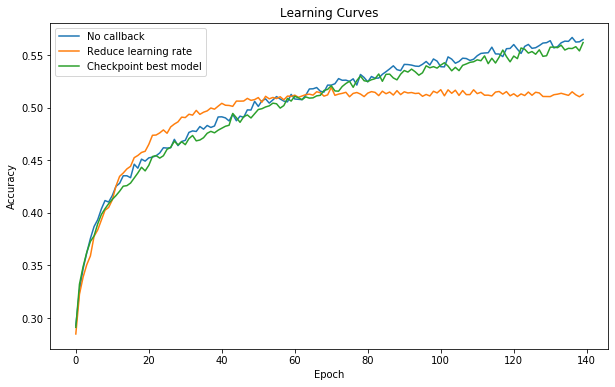

In [13]:
plt.figure(figsize = (10,6))
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
data = [("No callback", history_list_CRNN[0]), ("Reduce learning rate", history_list_CRNN[1]),("Checkpoint best model", history_list_CRNN[2])]
for i in data:
    plt.plot(i[1].history['accuracy'], label=i[0])
plt.legend()
plt.show()

As we can observe from the graph above using no callbacks led to the model with the highest training accuracy.

## Model 3

In [15]:
model_CRNN = keras.Sequential([

    layers.Conv1D(filters = 64, kernel_size =  5, activation='relu', padding='valid'),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPool1D(pool_size=(2), padding='same'),
    layers.Dropout(0.4),
    layers.Conv1D(filters = 64, kernel_size  =  5, activation='relu', padding='valid'),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPool1D(pool_size=(2), padding='same'),
    layers.Dropout(0.4),
    layers.Conv1D(filters = 64, kernel_size  =  5, activation='relu', padding='valid'),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPool1D(pool_size=(2), padding='same'),
    layers.Dropout(0.3),
    layers.LSTM(units=100),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=8, activation='softmax')
])
model_CRNN.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(3)])
history_CRNN = model_CRNN.fit(X_train, Y_train, epochs=180, batch_size=128, validation_data=(X_test, Y_test), shuffle = True)

Train on 19182 samples, validate on 1600 samples
Epoch 1/180
19182/19182 [==============================] - 6s 288us/sample - loss: 1.9699 - accuracy: 0.2867 - top_k_categorical_accuracy: 0.6120 - val_loss: 1.9966 - val_accuracy: 0.2600 - val_top_k_categorical_accuracy: 0.5625
Epoch 2/180
19182/19182 [==============================] - 2s 83us/sample - loss: 1.9295 - accuracy: 0.3310 - top_k_categorical_accuracy: 0.6548 - val_loss: 1.9769 - val_accuracy: 0.2912 - val_top_k_categorical_accuracy: 0.5763
Epoch 3/180
19182/19182 [==============================] - 2s 83us/sample - loss: 1.9086 - accuracy: 0.3561 - top_k_categorical_accuracy: 0.6702 - val_loss: 1.9417 - val_accuracy: 0.3175 - val_top_k_categorical_accuracy: 0.6075
Epoch 4/180
19182/19182 [==============================] - 2s 82us/sample - loss: 1.9009 - accuracy: 0.3631 - top_k_categorical_accuracy: 0.6783 - val_loss: 1.9563 - val_accuracy: 0.2875 - val_top_k_categorical_accuracy: 0.6212
Epoch 5/180
19182/19182 [=============

19182/19182 [==============================] - 2s 84us/sample - loss: 1.7940 - accuracy: 0.4738 - top_k_categorical_accuracy: 0.7454 - val_loss: 1.9129 - val_accuracy: 0.3525 - val_top_k_categorical_accuracy: 0.6488
Epoch 37/180
19182/19182 [==============================] - 2s 83us/sample - loss: 1.7900 - accuracy: 0.4777 - top_k_categorical_accuracy: 0.7470 - val_loss: 1.9091 - val_accuracy: 0.3600 - val_top_k_categorical_accuracy: 0.6687
Epoch 38/180
19182/19182 [==============================] - 2s 83us/sample - loss: 1.7912 - accuracy: 0.4776 - top_k_categorical_accuracy: 0.7498 - val_loss: 1.9369 - val_accuracy: 0.3262 - val_top_k_categorical_accuracy: 0.6488
Epoch 39/180
19182/19182 [==============================] - 2s 82us/sample - loss: 1.7909 - accuracy: 0.4784 - top_k_categorical_accuracy: 0.7478 - val_loss: 1.9296 - val_accuracy: 0.3288 - val_top_k_categorical_accuracy: 0.6513
Epoch 40/180
19182/19182 [==============================] - 2s 82us/sample - loss: 1.7881 - accur

Epoch 72/180
19182/19182 [==============================] - 2s 80us/sample - loss: 1.7524 - accuracy: 0.5168 - top_k_categorical_accuracy: 0.7669 - val_loss: 1.9368 - val_accuracy: 0.3288 - val_top_k_categorical_accuracy: 0.6425
Epoch 73/180
19182/19182 [==============================] - 2s 82us/sample - loss: 1.7499 - accuracy: 0.5204 - top_k_categorical_accuracy: 0.7689 - val_loss: 1.9268 - val_accuracy: 0.3388 - val_top_k_categorical_accuracy: 0.6550
Epoch 74/180
19182/19182 [==============================] - 2s 80us/sample - loss: 1.7472 - accuracy: 0.5222 - top_k_categorical_accuracy: 0.7704 - val_loss: 1.9323 - val_accuracy: 0.3300 - val_top_k_categorical_accuracy: 0.6562
Epoch 75/180
19182/19182 [==============================] - 2s 82us/sample - loss: 1.7460 - accuracy: 0.5241 - top_k_categorical_accuracy: 0.7735 - val_loss: 1.9463 - val_accuracy: 0.3162 - val_top_k_categorical_accuracy: 0.6612
Epoch 76/180
19182/19182 [==============================] - 2s 83us/sample - loss: 1

Epoch 108/180
19182/19182 [==============================] - 2s 82us/sample - loss: 1.7296 - accuracy: 0.5399 - top_k_categorical_accuracy: 0.7820 - val_loss: 1.9212 - val_accuracy: 0.3487 - val_top_k_categorical_accuracy: 0.6413
Epoch 109/180
19182/19182 [==============================] - 2s 81us/sample - loss: 1.7289 - accuracy: 0.5404 - top_k_categorical_accuracy: 0.7839 - val_loss: 1.9204 - val_accuracy: 0.3475 - val_top_k_categorical_accuracy: 0.6675
Epoch 110/180
19182/19182 [==============================] - 2s 81us/sample - loss: 1.7252 - accuracy: 0.5464 - top_k_categorical_accuracy: 0.7837 - val_loss: 1.9155 - val_accuracy: 0.3575 - val_top_k_categorical_accuracy: 0.6662
Epoch 111/180
19182/19182 [==============================] - 2s 81us/sample - loss: 1.7241 - accuracy: 0.5462 - top_k_categorical_accuracy: 0.7837 - val_loss: 1.9213 - val_accuracy: 0.3425 - val_top_k_categorical_accuracy: 0.6625
Epoch 112/180
19182/19182 [==============================] - 2s 81us/sample - lo

Epoch 144/180
19182/19182 [==============================] - 2s 81us/sample - loss: 1.7083 - accuracy: 0.5628 - top_k_categorical_accuracy: 0.7915 - val_loss: 1.9247 - val_accuracy: 0.3438 - val_top_k_categorical_accuracy: 0.6700
Epoch 145/180
19182/19182 [==============================] - 2s 81us/sample - loss: 1.7048 - accuracy: 0.5664 - top_k_categorical_accuracy: 0.7940 - val_loss: 1.9378 - val_accuracy: 0.3262 - val_top_k_categorical_accuracy: 0.6562
Epoch 146/180
19182/19182 [==============================] - 2s 81us/sample - loss: 1.6989 - accuracy: 0.5724 - top_k_categorical_accuracy: 0.7967 - val_loss: 1.9201 - val_accuracy: 0.3450 - val_top_k_categorical_accuracy: 0.6575
Epoch 147/180
19182/19182 [==============================] - 2s 83us/sample - loss: 1.7090 - accuracy: 0.5612 - top_k_categorical_accuracy: 0.7963 - val_loss: 1.9353 - val_accuracy: 0.3350 - val_top_k_categorical_accuracy: 0.6662
Epoch 148/180
19182/19182 [==============================] - 2s 82us/sample - lo

Epoch 180/180
19182/19182 [==============================] - 2s 81us/sample - loss: 1.6887 - accuracy: 0.5823 - top_k_categorical_accuracy: 0.8038 - val_loss: 1.9099 - val_accuracy: 0.3562 - val_top_k_categorical_accuracy: 0.6637


In [16]:
model_CRNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              multiple                  20544     
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) multiple                  0         
_________________________________________________________________
dropout_7 (Dropout)          multiple                  0         
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  20544     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 multiple                 

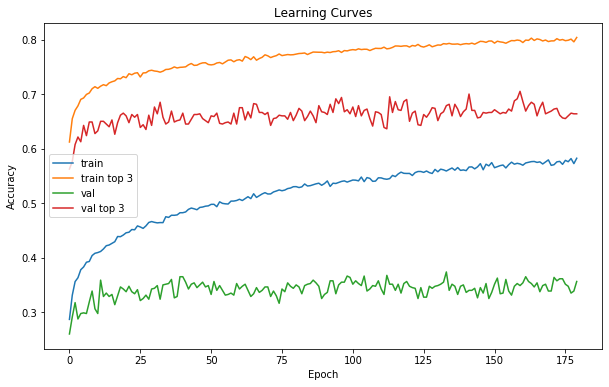

In [17]:
plt.figure(figsize = (10,6))
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history_CRNN.history['accuracy'], label='train')
plt.plot(history_CRNN.history['top_k_categorical_accuracy'], label='train top 3')
plt.plot(history_CRNN.history['val_accuracy'], label='val')
plt.plot(history_CRNN.history['val_top_k_categorical_accuracy'], label='val top 3')
plt.legend()
plt.show()

After experimenting with different kernel sizes, a different number of units, varying tuning hyperparameters and optimisers, this was the best performing CRNN model I could build.

## Evaluating all 3 models

As there are eight equally represented classes one baseline we can use is a random model which predicts each class with equal probability, this would have an expected accuracy of $\frac{1}{8} = 0.125$. Any model which is simply guessing would have the same expected accuracy. All three of our models have a significantly larger accuracy than this baseline. 

First let us take a look at the first 10 predictions for each model.

In [18]:
y_true = np.argmax(Y_valid, axis = 1)
print(y_true[:10]) # True outputs

[4 3 5 3 3 3 5 4 5 5]


In [19]:
yhat = model_FFNN.predict(X_valid)
yhat_FFNN = np.argmax(yhat, axis=1)
print (yhat_FFNN[:10]) # Model 1

[0 7 2 3 3 3 7 4 5 5]


In [20]:
yhat = model_CNN.predict(X_valid)
yhat_CNN = np.argmax(yhat, axis=1)
print (yhat_CNN[:10]) # Model 2

[4 7 5 3 7 0 2 3 2 2]


In [21]:
yhat = model_CRNN.predict(X_valid)
yhat_CRNN = np.argmax(yhat, axis=1)
print (yhat_CRNN[:10]) # Model 3

[3 7 2 3 3 3 2 7 2 2]


### Ensemble models 
Ensemble learning combines the predictions from multiple models in order to reduce the variance of predictions.

Here we create an ensemble predictor and a weighted ensemble predictor. The weighted ensemble predictor utilises the observation that our CNN model (model 2) performed the best while training, so we give it twice as much weight.

In [22]:
models = [model_FFNN, model_CNN, model_CRNN]

def ensemble_predictions(models, data):
    # make predictions
    yhats = [model.predict(data) for model in models]
    yhats = np.array(yhats)
    sums = np.sum(yhats, axis=0) # Sum predictions
    return np.argmax(sums, axis=1) # Return the prediction with highest likelyhood

def ensemble_weighted_predictions(models, data):
    # make predictions
    yhats = [model.predict(data) for model in models]
    yhats = np.array(yhats)
    a = np.average(yhats, axis=0, weights = [0.25, 0.5, 0.25]) # Get a weighted average
    return np.argmax(a, axis=1) # Return the prediction with highest probability

In [23]:
yhat_ensemble = ensemble_predictions(models, X_valid)
print (yhat_ensemble[:10]) # Equally weighted ensemble (Model 4)

[4 7 2 3 3 3 2 4 2 2]


In [24]:
yhat_weight_ensemble = ensemble_weighted_predictions(models, X_valid)
print (yhat_weight_ensemble[:10]) # Weighted ensemble (Model 5)

[4 7 5 3 7 3 2 3 2 2]


### Here we can obtain a classification report for each of the five models.
#### We will use the following metrics.
#### Accuracy
$$Accuracy = \frac{True\; positives + True\; negatives}{True\; positives + False\; positives + True\; negatives+ False\; negatives}$$

#### Precision
This refers to the percentage of your results which are relevant.
$$Precision = \frac{True\; positives}{True\; positives + False\; positives}$$

#### Recall
This can be thought of as the percentage of total relevant results correctly classified.
$$Precision = \frac{True\; positives}{True\; positives + False\; negatives}$$

#### F1- score
This is a harmonic mean of precision and recall, a harmonic mean punishes low values, to a much larger extent than a standard mean.
$$F_1 = \frac{2*precision*recall}{precision + recall}$$

In [29]:
from sklearn.metrics import classification_report
genre_dict = {'Electronic':0,  'Hip-Hop':1, 
               'Instrumental':2, 'Rock': 3, 'Experimental':4, 'Folk':5, 'International':6, 'Pop' :7}
target_name = genre_dict.keys()
preds = [("FFNN (Model 1)", yhat_FFNN), ("CNN (Model 2)", yhat_CNN), ("CRNN (Model 3)", yhat_CRNN), 
         ("Simple Ensemble", yhat_ensemble), ("Weighted Ensemble (Model 5)", yhat_weight_ensemble)]
for x in preds:
    print(y_true.shape, x[1].shape, x[0])
    print(classification_report(y_true, x[1], target_names=target_name))

(1600,) (1600,) FFNN (Model 1)
               precision    recall  f1-score   support

   Electronic       0.32      0.44      0.37       200
      Hip-Hop       0.45      0.42      0.44       200
 Instrumental       0.35      0.27      0.31       200
         Rock       0.57      0.51      0.54       200
 Experimental       0.33      0.29      0.31       200
         Folk       0.55      0.65      0.59       200
International       0.45      0.39      0.42       200
          Pop       0.16      0.17      0.16       200

     accuracy                           0.39      1600
    macro avg       0.40      0.39      0.39      1600
 weighted avg       0.40      0.39      0.39      1600

(1600,) (1600,) CNN (Model 2)
               precision    recall  f1-score   support

   Electronic       0.46      0.51      0.49       200
      Hip-Hop       0.64      0.52      0.57       200
 Instrumental       0.41      0.41      0.41       200
         Rock       0.61      0.50      0.55       200


## Final model and findings.

#### Looking at the results above I have decided to go with the weighted ensemble model, for the following reasons:
1. It has the best performance overall. It outperforms all other models in terms of accuracy.
2. It has the best $F_1$ score for Electronic, Hip-Hop, Rock and Experimental music classification. It is the second-best performing model for Instrumental, Folk and International music. It is third for pop music, but all models are very poor at classifying pop music.
3. As it is a combination of models it has lower variance than any individual model. Its improved performance over the simple ensemble model helped me choose this.

Below is a confusion_matrix from this Weighted ensemble model.
From this and the classification report above we observe that:
1. Pop is the hardest music genre to classify, likely due to the wide variety of sounds it includes and its lack of defining characteristics. Every model performs similarly to or worse than a random guess  at classifying pop.
2. Folk and Rock are the easiest to classify by every model, likely due to the distinct sound of these genres.
3. Instrumental is most commonly misclassified as Folk, and interestingly pop is commonly misclassified as experimental. 
4. Pop music is classified as each different genre, at least as much as it is classified correctly as pop.


Text(83.40000000000006, 0.5, 'predicted label')

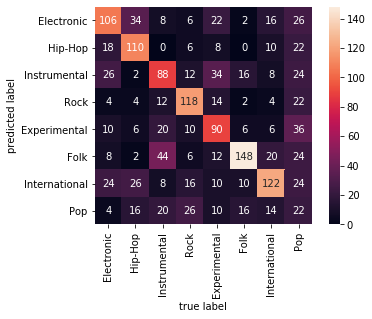

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y_true, yhat_weight_ensemble)
sns.heatmap(mat.T, square = True, annot = True, fmt='d',
            xticklabels = genre_dict.keys(),
            yticklabels = genre_dict.keys())
plt.xlabel('true label')
plt.ylabel('predicted label')

## References

https://en.wikipedia.org/wiki/Fourier_transform [0]

https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53 [1]

https://www.britannica.com/science/sound-physics/The-decibel-scale [2]

https://en.wikipedia.org/wiki/Bilinear_interpolation [3]

https://github.com/mdeff/fma [4]

http://cs229.stanford.edu/proj2015/054_report.pdf [5]

https://arxiv.org/pdf/1609.04243.pdf [6]